## Setting Device

In [1]:
import torch

# Change X to the GPU number you want to use,
# e.g. USE_GPU = 4
USE_GPU = 4

print ('Available devices: ', torch.cuda.device_count())
device = torch.device("cuda:"+str(USE_GPU) if torch.cuda.is_available() else "cpu")
print("device: ", device)

Available devices:  8
device:  cuda:4


# GCN Model

In [2]:
import numpy as np
import torch
from torch_geometric.data import Data, Batch
import torch_geometric.nn as gnn
import torch.nn.functional as F

class CorNet(torch.nn.Module):
    def __init__(self):
        super(CorNet, self).__init__()

#         self.sage1_max = gnn.SAGEConv(2, 6, aggr='max', root_weight=True)
#         self.sage2_max = gnn.SAGEConv(6, 10, aggr='max', root_weight=True)
        
#         self.sage1_min = gnn.SAGEConv(2, 6, aggr='min', root_weight=True)
#         self.sage2_min = gnn.SAGEConv(6, 10, aggr='min', root_weight=True)
        
        self.sage1_mean = gnn.SAGEConv(2, 6, aggr='mean', root_weight=True)
        self.sage2_mean = gnn.SAGEConv(6, 10, aggr='mean', root_weight=True)
        
        self.sage1_sum = gnn.SAGEConv(2, 6, aggr='sum', root_weight=True)
        self.sage2_sum = gnn.SAGEConv(6, 10, aggr='sum', root_weight=True)

#         self.bn1_max = gnn.BatchNorm(6)
#         self.bn2_max = gnn.BatchNorm(10)
        
#         self.bn1_min = gnn.BatchNorm(6)
#         self.bn2_min = gnn.BatchNorm(10)
        
        self.bn1_mean = gnn.BatchNorm(6)
        self.bn2_mean = gnn.BatchNorm(10)
        
        self.bn1_sum = gnn.BatchNorm(6)
        self.bn2_sum = gnn.BatchNorm(10)

        self.fc = gnn.Linear(20, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # # Max Aggregation Layers
        # x_max = self.sage1_max(x, edge_index)
        # x_max = self.bn1_max(x_max)
        # x_max = F.relu(x_max)
        # x_max = self.sage2_max(x_max, edge_index)
        # x_max = self.bn2_max(x_max)
        # x_max = F.relu(x_max)

        # # Min Aggregation Layers
        # x_min = self.sage1_min(x, edge_index)
        # x_min = self.bn1_min(x_min)
        # x_min = F.relu(x_min)
        # x_min = self.sage2_min(x_min, edge_index)
        # x_min = self.bn2_min(x_min)
        # x_min = F.relu(x_min)

        # Mean Aggregation Layers
        x_mean = self.sage1_mean(x, edge_index)
        x_mean = self.bn1_mean(x_mean)
        x_mean = F.relu(x_mean)
        x_mean = self.sage2_mean(x_mean, edge_index)
        x_mean = self.bn2_mean(x_mean)
        x_mean = F.relu(x_mean)
        
        # Sum Aggregation Layers
        x_sum = self.sage1_sum(x, edge_index)
        x_sum = self.bn1_sum(x_sum)
        x_sum = F.relu(x_sum)
        x_sum = self.sage2_sum(x_sum, edge_index)
        x_sum = self.bn2_sum(x_sum)
        x_sum = F.relu(x_sum)
        
        x_concat = torch.cat((x_mean, x_sum), 1)
        x_concat = self.fc(x_concat)
        
        return F.sigmoid(x_concat)

class BuildingGenModel(torch.nn.Module):
    def __init__(self):
        super(BuildingGenModel, self).__init__()
        self.rm_l1 = gnn.SAGEConv(2, 32, aggr='min')
        self.rm_norm1 = gnn.BatchNorm(32)
        self.rm_l2 = gnn.SAGEConv(32, 16, aggr='min')
        self.rm_norm2 = gnn.BatchNorm(16)
        self.rm_l3 = gnn.SAGEConv(16, 1, aggr='min')
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        rm = F.relu(self.rm_norm1(self.rm_l1(x, edge_index)))

        rm = F.relu(self.rm_norm2(self.rm_l2(rm, edge_index)))

        rm = self.rm_l3(rm, edge_index)
        
        return F.sigmoid(rm)

# Dataset

In [3]:
from data import BuildingFootprintsDataset

dataset = BuildingFootprintsDataset(centroid=False)

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')

Dataset: BuildingFootprintsDataset(19835):
Number of graphs: 19835
Number of features: 2


## Dataset Splitting

Split into test, validate, and training sets

In [4]:
from torch_geometric.loader import DataLoader

dataset_idx = np.array(list(range(len(dataset))))
np.random.shuffle(dataset_idx)

# Randomly select specified number of graphs from the dataset
selected_polys = 1280
selected_idx = dataset_idx[:selected_polys]

# Split into test, validate, and training sets
test_split = int(np.floor(0.2 * len(selected_idx)))
val_split = int(np.floor(0.15 * len(selected_idx)) + test_split)

test_idx = selected_idx[:test_split]
val_idx = selected_idx[test_split:val_split]
train_idx = selected_idx[val_split:]

# show details of these sets
dataset[selected_idx]
print(f'Selected set from Dataset: {dataset[selected_idx]}:')
print('======================')
print(f'Number of graphs: {len(dataset[selected_idx])}\n')

test_set = dataset[test_idx]
print(f'Test set: {test_set}:')
print('======================')
print(f'Number of graphs: {len(test_set)}\n')

val_set = dataset[val_idx]
print(f'Validate set: {val_set}:')
print('======================')
print(f'Number of graphs: {len(val_set)}\n')

train_set = dataset[train_idx]
print(f'Training set: {train_set}:')
print('======================')
print(f'Number of graphs: {len(train_set)}\n')

# Validate the numbers of graphs in these sets
split_validate = len(dataset[selected_idx])==( len(test_set) + len(val_set) + len(train_set) )
print(f'Train+Val+Test sets == Selected set : {split_validate}')

# Create loader for each set
test_loader = DataLoader(test_set, batch_size=32)
val_loader = DataLoader(val_set, batch_size=32)
train_loader = DataLoader(train_set, batch_size=32)

Selected set from Dataset: BuildingFootprintsDataset(1280):
Number of graphs: 1280

Test set: BuildingFootprintsDataset(256):
Number of graphs: 256

Validate set: BuildingFootprintsDataset(192):
Number of graphs: 192

Training set: BuildingFootprintsDataset(832):
Number of graphs: 832

Train+Val+Test sets == Selected set : True


# Create functions for training, validating, and testing

In [5]:
from sklearn import metrics
import matplotlib.pyplot as plt

def train(model, train_loader, optimizer, loss_func, epoch, device):
    model.to(device)
    model.train()
    train_epoch_loss = 0.0
    train_batch_losses = np.array([])
    for batch_idx, batch in enumerate(train_loader):
        batch = batch.to(device)

        optimizer.zero_grad()

        output = model(batch)
        output = output.squeeze()
        loss = loss_func(output, batch.y.float(), reduction='mean')
        loss.backward()

        optimizer.step()

        train_epoch_loss += loss.item()
        train_batch_losses = np.append(train_batch_losses, loss.item())
        
        batch_c = batch_idx+1
        print('Train Epoch: {} [{}/{} ({:.0f}%)] - Loss: {:.6f}'.format(
                epoch, batch_c * batch.num_graphs, len(train_loader.dataset),
                100. * batch_c / len(train_loader), train_epoch_loss / batch_c), end='\r')

    return train_epoch_loss / len(train_loader), train_batch_losses

def validate(model, validate_loader, loss_func, device):
    model.to(device)
    model.eval()
    val_epoch_loss = 0.0
    val_batch_losses = np.array([])
    IoU = 0.0
    accuracy = 0.0
    with torch.no_grad():
        for batch_idx, batch in enumerate(validate_loader):
            batch = batch.to(device)
            
            output = model(batch)
            output = output.squeeze()
            
            loss = loss_func(output, batch.y.float(), reduction='mean')
            val_epoch_loss += loss.item()
            val_batch_losses = np.append(val_batch_losses, loss.item())

            pred = (output >= 0.5).int().cpu()
            target = batch.y.float().cpu()
            accuracy += pred.eq(target).sum().item() / batch.num_nodes
            
            intersection = (output * batch.y).sum().item()
            union = output.sum().item() + batch.y.sum().item() - intersection
            IoU += (intersection/union)
             
    val_epoch_loss /= len(validate_loader)
    IoU /= len(validate_loader)
    accuracy /= len(validate_loader)
    
    print('\nValidate set - Loss: {:.6f} - IoU: {:.6f} - Accuracy: {:.6f}'.format(val_epoch_loss, IoU, accuracy), end='\r')
    print('\n')
    
    return val_epoch_loss, val_batch_losses

def test(model, test_loader, loss_func, device):
    model.to(device)
    model.eval()
    test_loss = 0.0
    IoU = 0.0
    accuracy = 0.0
    test_target = np.array([])
    prediction = np.array([])
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            batch = batch.to(device)
            
            output = model(batch)
            output = output.squeeze()
            test_loss += loss_func(output, batch.y.float(), reduction='mean').item()

            pred = (output >= 0.5).int().cpu()
            target = batch.y.float().cpu()
            accuracy += pred.eq(target).sum().item() / batch.num_nodes
            
            intersection = (output * batch.y).sum().item()
            union = output.sum().item() + batch.y.sum().item() - intersection
            IoU += (intersection/union)
            
            test_target = np.append(test_target, batch.y.float().cpu().numpy())
            prediction = np.append(prediction, pred.numpy())
             
    test_loss /= len(test_loader)
    IoU /= len(test_loader)
    accuracy /= len(test_loader)
    
    print('\nTest set - Average Loss: {:.6f} - IoU: {:.6f} - Accuracy: {:.6f}\n'.format(test_loss, IoU, accuracy))
    
    disp = metrics.ConfusionMatrixDisplay.from_predictions(test_target, prediction, 
                                                           # display_labels = list(idx_to_class.values()), 
                                                           xticks_rotation = 'vertical')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()

# Training procedure and Optimization

Train Epoch: 1 [832/832 (100%)] - Loss: 0.573830
Validate set - Loss: 0.529371 - IoU: 0.263600 - Accuracy: 0.776346

Train Epoch: 2 [832/832 (100%)] - Loss: 0.314476
Validate set - Loss: 0.312983 - IoU: 0.467434 - Accuracy: 0.894192

Train Epoch: 3 [832/832 (100%)] - Loss: 0.136520
Validate set - Loss: 0.151817 - IoU: 0.723851 - Accuracy: 0.956225

Train Epoch: 4 [832/832 (100%)] - Loss: 0.082957
Validate set - Loss: 0.084645 - IoU: 0.831950 - Accuracy: 0.971781

Train Epoch: 5 [832/832 (100%)] - Loss: 0.064013
Validate set - Loss: 0.046568 - IoU: 0.888615 - Accuracy: 0.988899

Train Epoch: 6 [832/832 (100%)] - Loss: 0.038223
Validate set - Loss: 0.036881 - IoU: 0.912228 - Accuracy: 0.990369

Train Epoch: 7 [832/832 (100%)] - Loss: 0.034440
Validate set - Loss: 0.034045 - IoU: 0.917072 - Accuracy: 0.990902

Train Epoch: 8 [832/832 (100%)] - Loss: 0.031968
Validate set - Loss: 0.032009 - IoU: 0.921614 - Accuracy: 0.992659

Train Epoch: 9 [832/832 (100%)] - Loss: 0.029908
Validate set - 

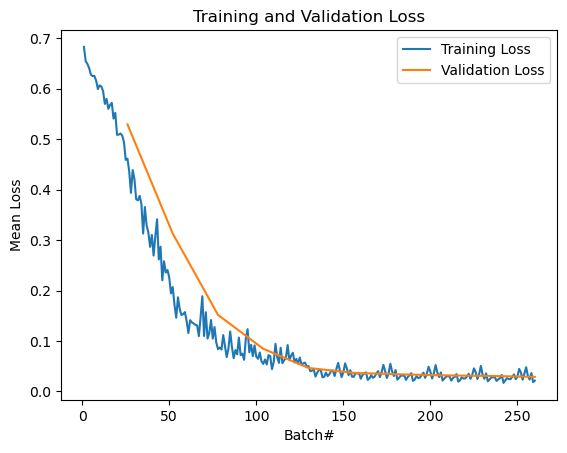

In [6]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

model = CorNet()
optimizer = Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
loss_func = F.binary_cross_entropy

min_train_loss = np.Inf
last_validate_loss = np.Inf

num_epoch = 10
train_losses_plot = np.array([])
val_losses_plot = np.array([])

for epoch in range(1,num_epoch + 1):
    train_epoch_loss, train_batch_losses = train(model, train_loader, optimizer, loss_func, epoch, device)
    val_epoch_loss, val_batch_losses = validate(model, val_loader, loss_func, device)
    
    # Early Stopping conditions
    if val_epoch_loss > last_validate_loss and train_epoch_loss < min_train_loss:
        break
    # Save the model trained so far.
    torch.save(model, 'corner.pt')
    last_validate_loss = val_epoch_loss
    if train_epoch_loss < min_train_loss:
        min_train_loss = train_epoch_loss
    
    train_losses_plot = np.append(train_losses_plot, train_batch_losses)
    val_losses_plot = np.append(val_losses_plot, val_epoch_loss)
    
    scheduler.step()
    
train_batches = np.arange(1, train_losses_plot.shape[0]+1)
# train_epochs = np.arange(1/train_batches, 10+(1/train_batches), 1/train_batches)

val_batches = np.arange(len(train_loader), train_losses_plot.shape[0]+1, len(train_loader))
# val_epochs = np.arange(1/val_batches, 10+(1/val_batches), 1/val_batches)

plt.plot(train_batches, train_losses_plot, label='Training Loss')
plt.plot(val_batches, val_losses_plot, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Batch#')
plt.ylabel('Mean Loss')

# Set the tick locations
# plt.xticks(arange(0, 21, 2))

# Display the plot
plt.legend(loc='best')
plt.show()

# Testing


Test set - Average Loss: 0.032209 - IoU: 0.922926 - Accuracy: 0.991742



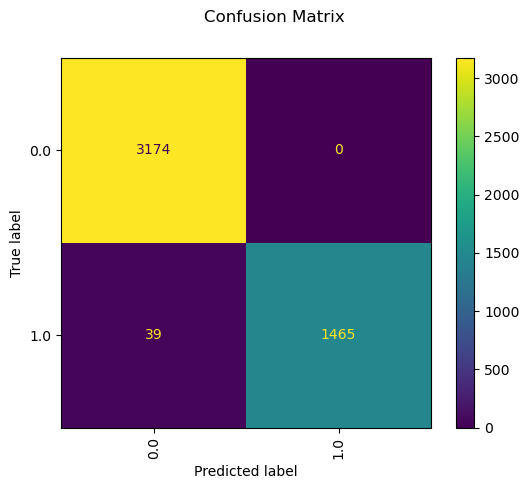

In [7]:
model = torch.load('corner.pt')
test(model, test_loader, loss_func, device)

## Look for the incorrect predictions

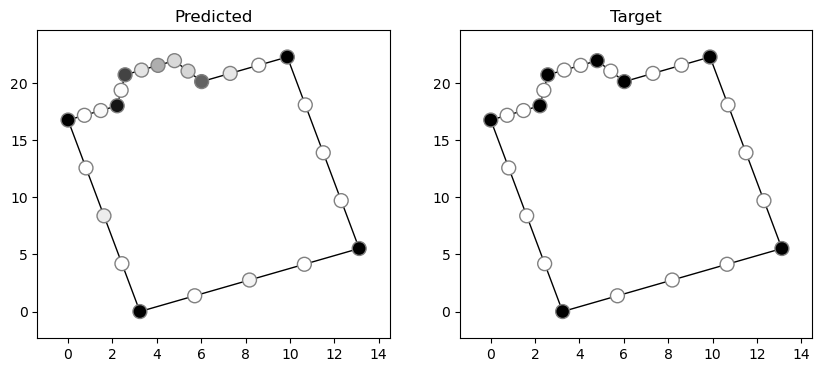

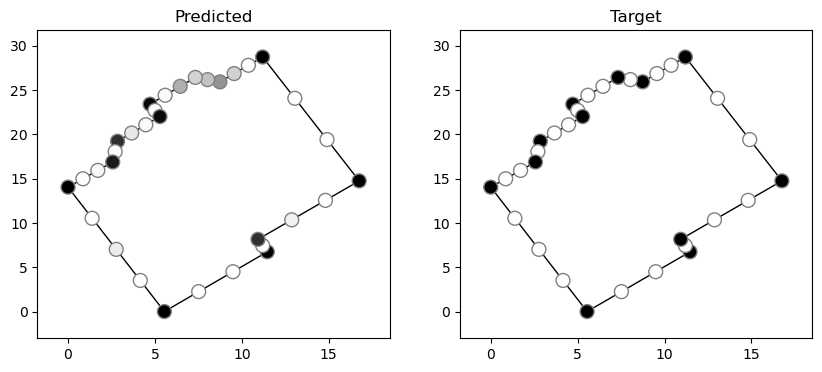

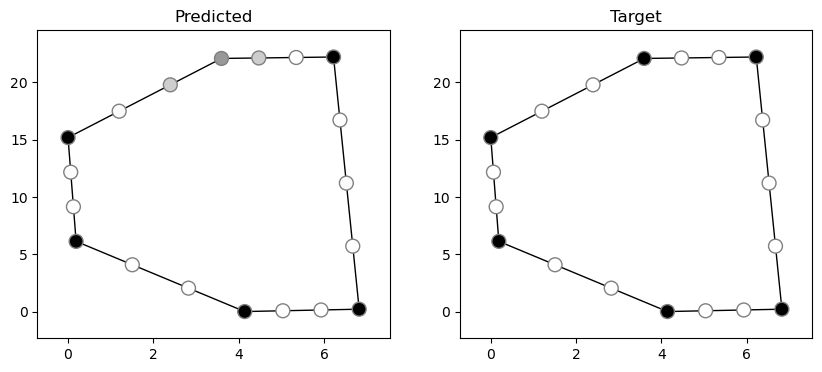

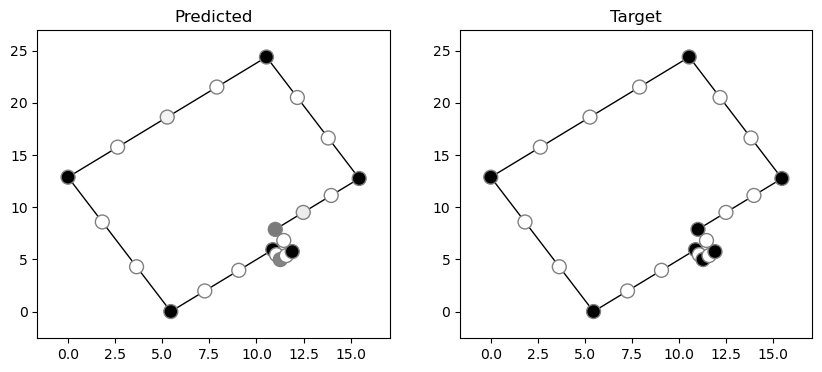

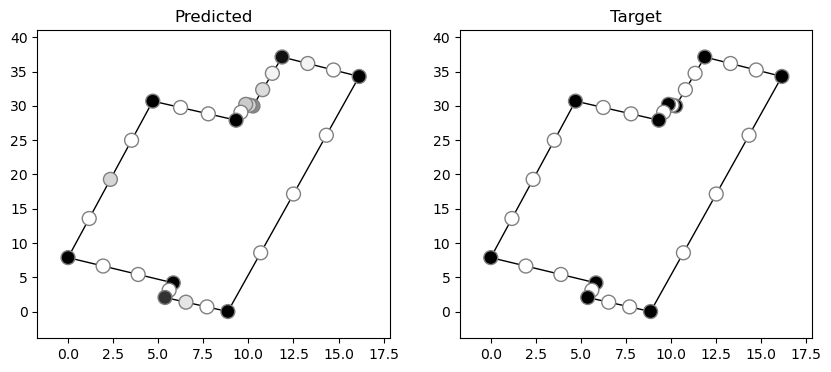

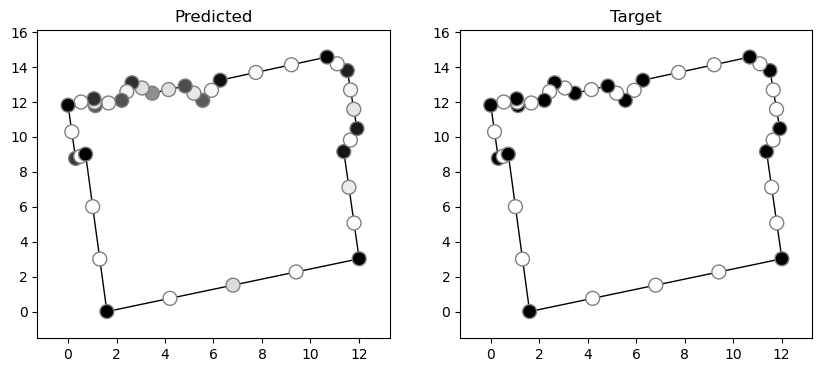

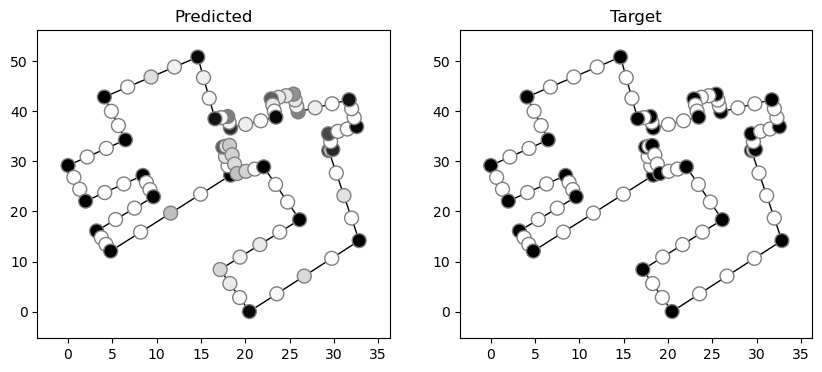

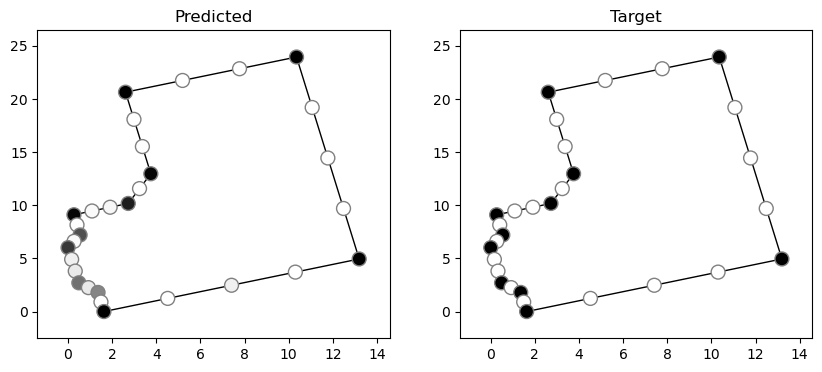

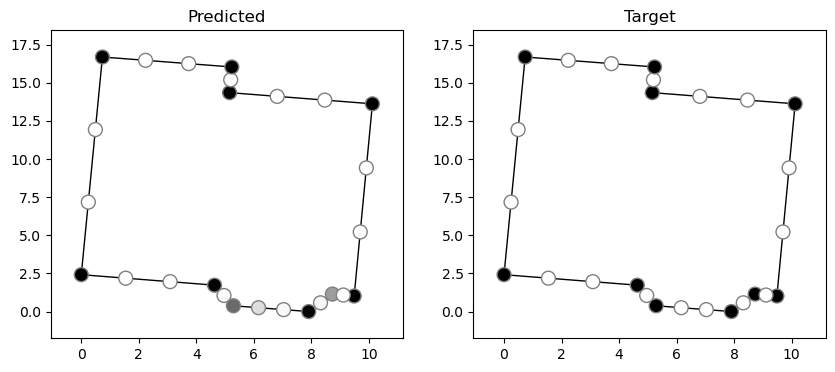

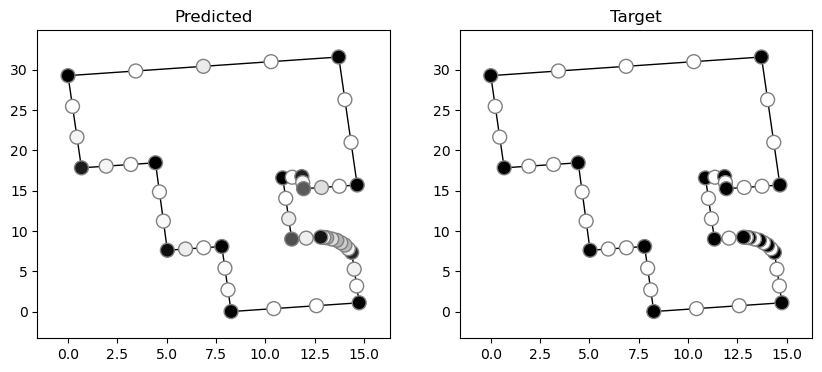

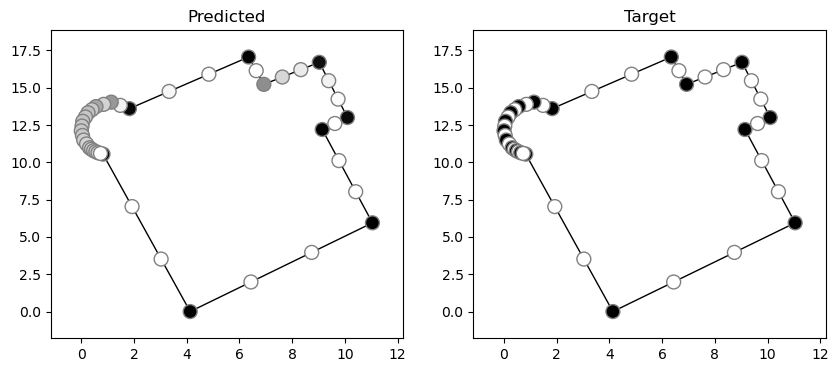

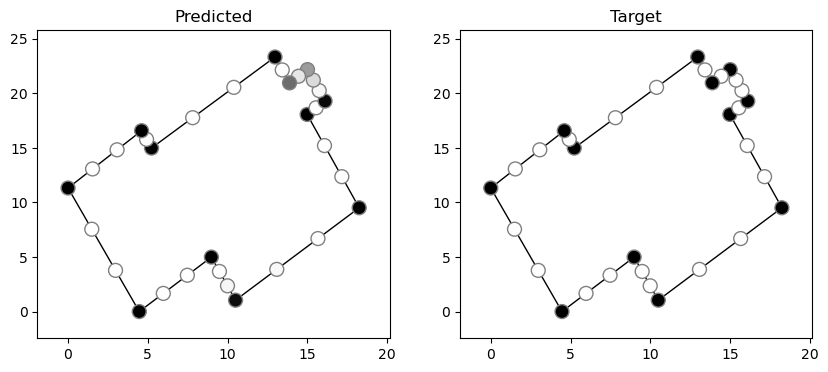

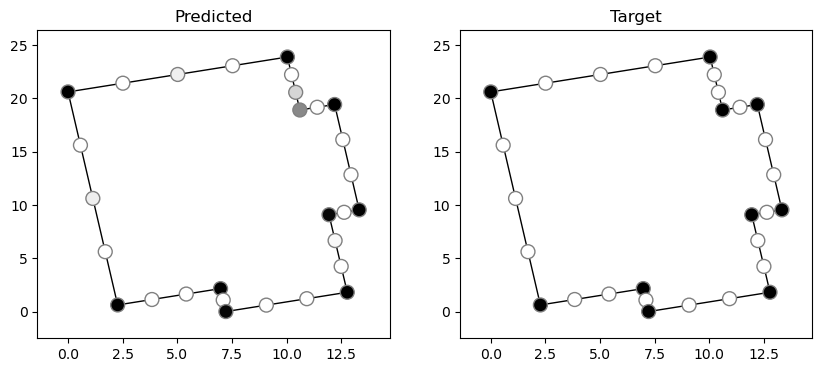

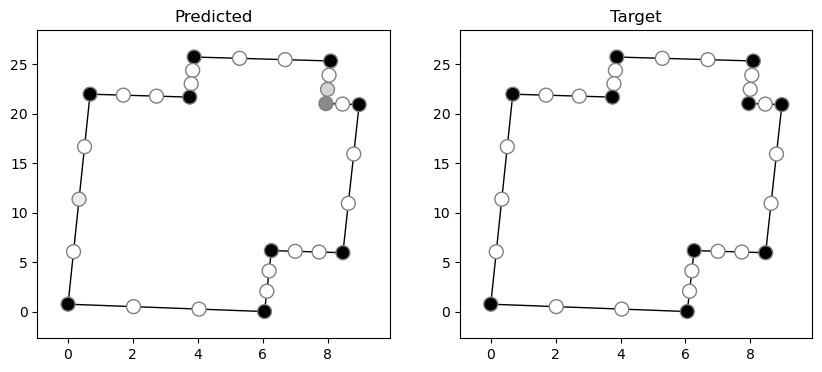

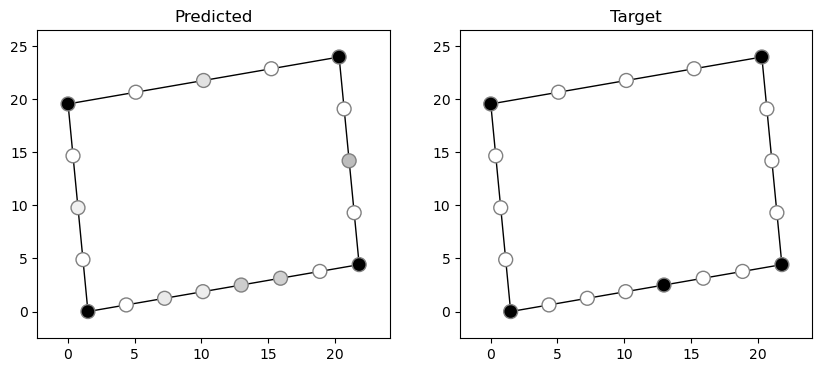

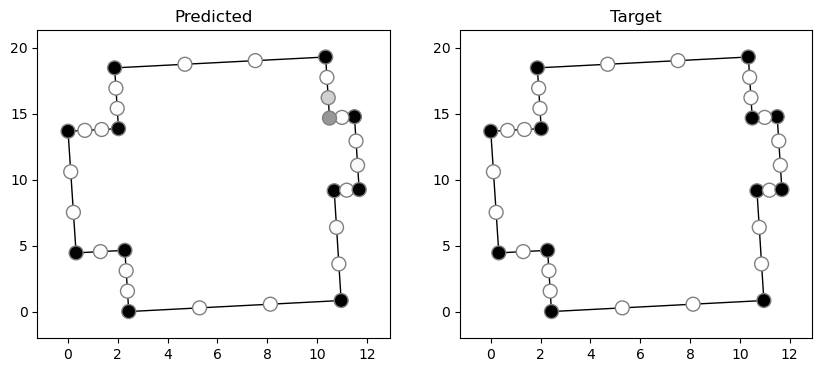

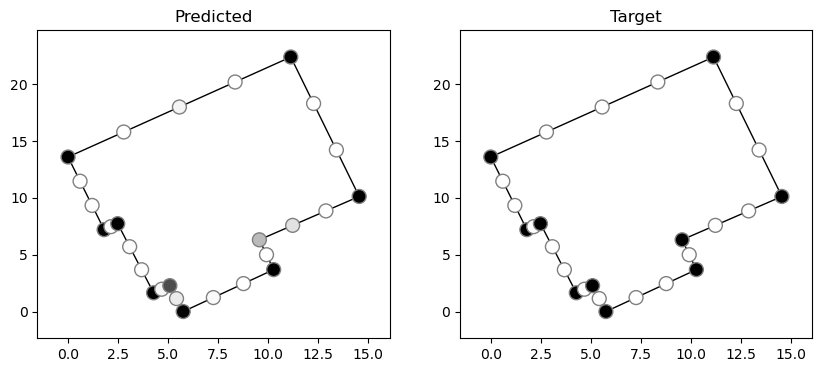

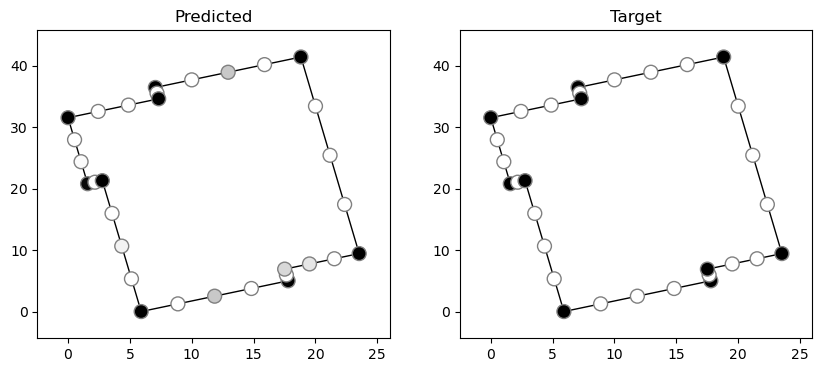

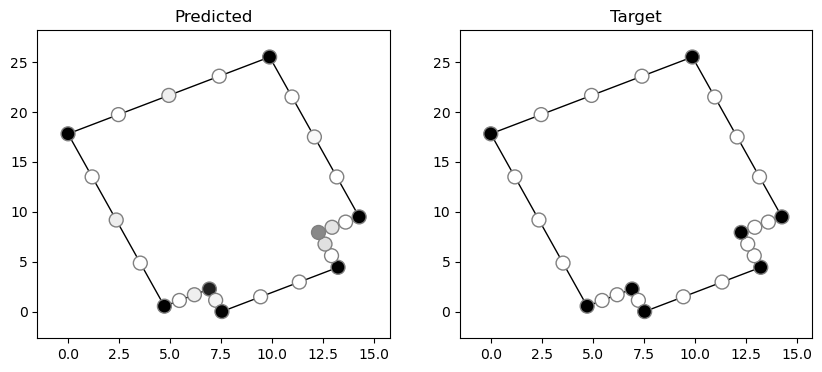

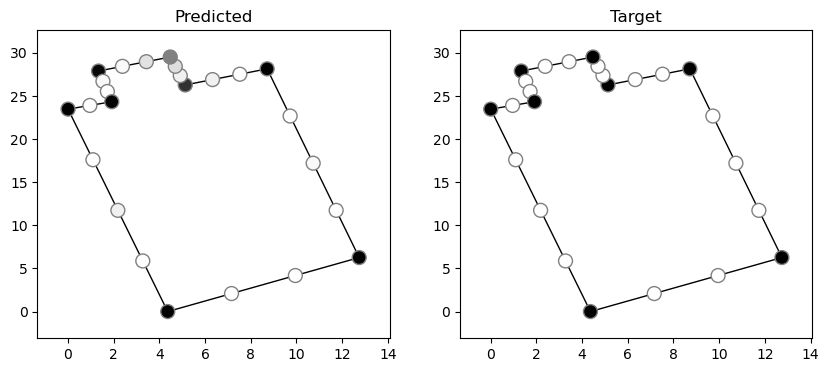

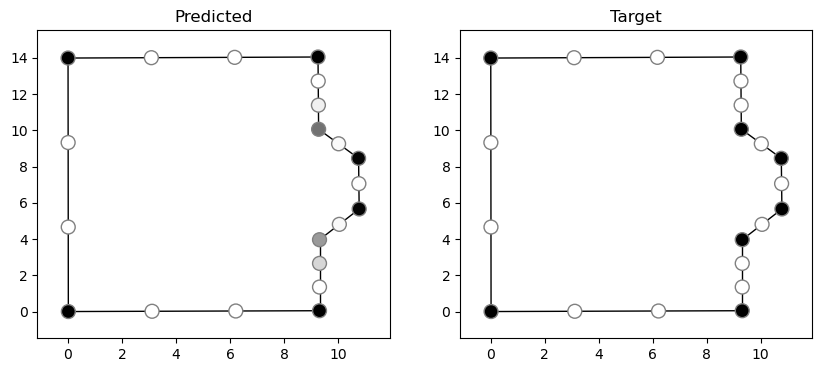

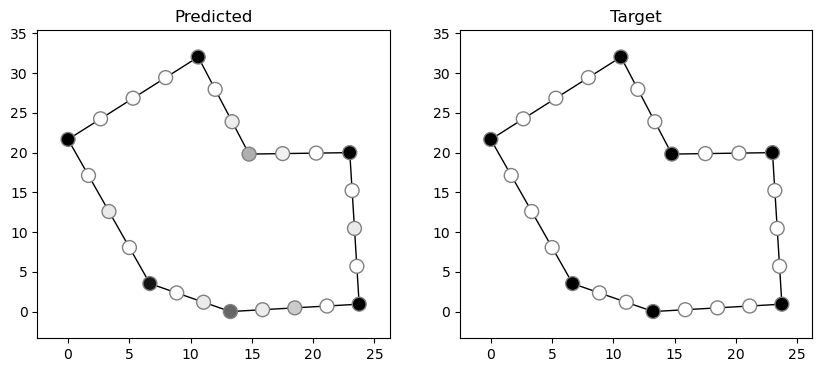

In [8]:
import networkx as nx
from torch_geometric.utils import to_networkx

for data in test_set:
    data.to(device)
    y_pred = model(data).detach().cpu()
    y_pred = y_pred.squeeze().cpu()
    pred = (y_pred >= 0.5).int()
    target = data.y.float().cpu()
    
    incorrect = pred.ne(target).sum().item()
    
    if incorrect > 0:
        pos = {}
        for i, coords in enumerate(data.x.cpu().numpy()):
            pos[i] = (coords[0], coords[1])

        g = to_networkx(data, to_undirected=True)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
        nx.draw(g, pos, ax=ax1, node_size=100, node_color=y_pred, edgecolors='grey', cmap='binary')
        ax1.axis("on")
        ax1.set_title("Predicted")
        ax1.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        
        nx.draw(g, pos, ax=ax2, node_size=100, node_color=target, edgecolors='grey', cmap='binary')
        ax2.axis("on")
        ax2.set_title("Target")
        ax2.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        
        plt.show()

# Model Summary

In [9]:
def count_parameters(m):
    total_params = 0
    for name, parameter in m.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        print(f"{name}\t:\t{params}")
        total_params += params
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

sage1_mean.lin_l.weight	:	12
sage1_mean.lin_l.bias	:	6
sage1_mean.lin_r.weight	:	12
sage2_mean.lin_l.weight	:	60
sage2_mean.lin_l.bias	:	10
sage2_mean.lin_r.weight	:	60
sage1_sum.lin_l.weight	:	12
sage1_sum.lin_l.bias	:	6
sage1_sum.lin_r.weight	:	12
sage2_sum.lin_l.weight	:	60
sage2_sum.lin_l.bias	:	10
sage2_sum.lin_r.weight	:	60
bn1_mean.module.weight	:	6
bn1_mean.module.bias	:	6
bn2_mean.module.weight	:	10
bn2_mean.module.bias	:	10
bn1_sum.module.weight	:	6
bn1_sum.module.bias	:	6
bn2_sum.module.weight	:	10
bn2_sum.module.bias	:	10
fc.weight	:	20
fc.bias	:	1
Total Trainable Params: 405


405

## Randomly show some buildings in the test set with corner prediction.

In [10]:
test_disp_idx = list(range(len(test_set)))
np.random.shuffle(test_disp_idx)

test_disp = test_set[test_disp_idx[0:9]]

model.to(device)
model.eval()

CorNet(
  (sage1_mean): SAGEConv(2, 6, aggr=mean)
  (sage2_mean): SAGEConv(6, 10, aggr=mean)
  (sage1_sum): SAGEConv(2, 6, aggr=sum)
  (sage2_sum): SAGEConv(6, 10, aggr=sum)
  (bn1_mean): BatchNorm(6)
  (bn2_mean): BatchNorm(10)
  (bn1_sum): BatchNorm(6)
  (bn2_sum): BatchNorm(10)
  (fc): Linear(20, 1, bias=True)
)

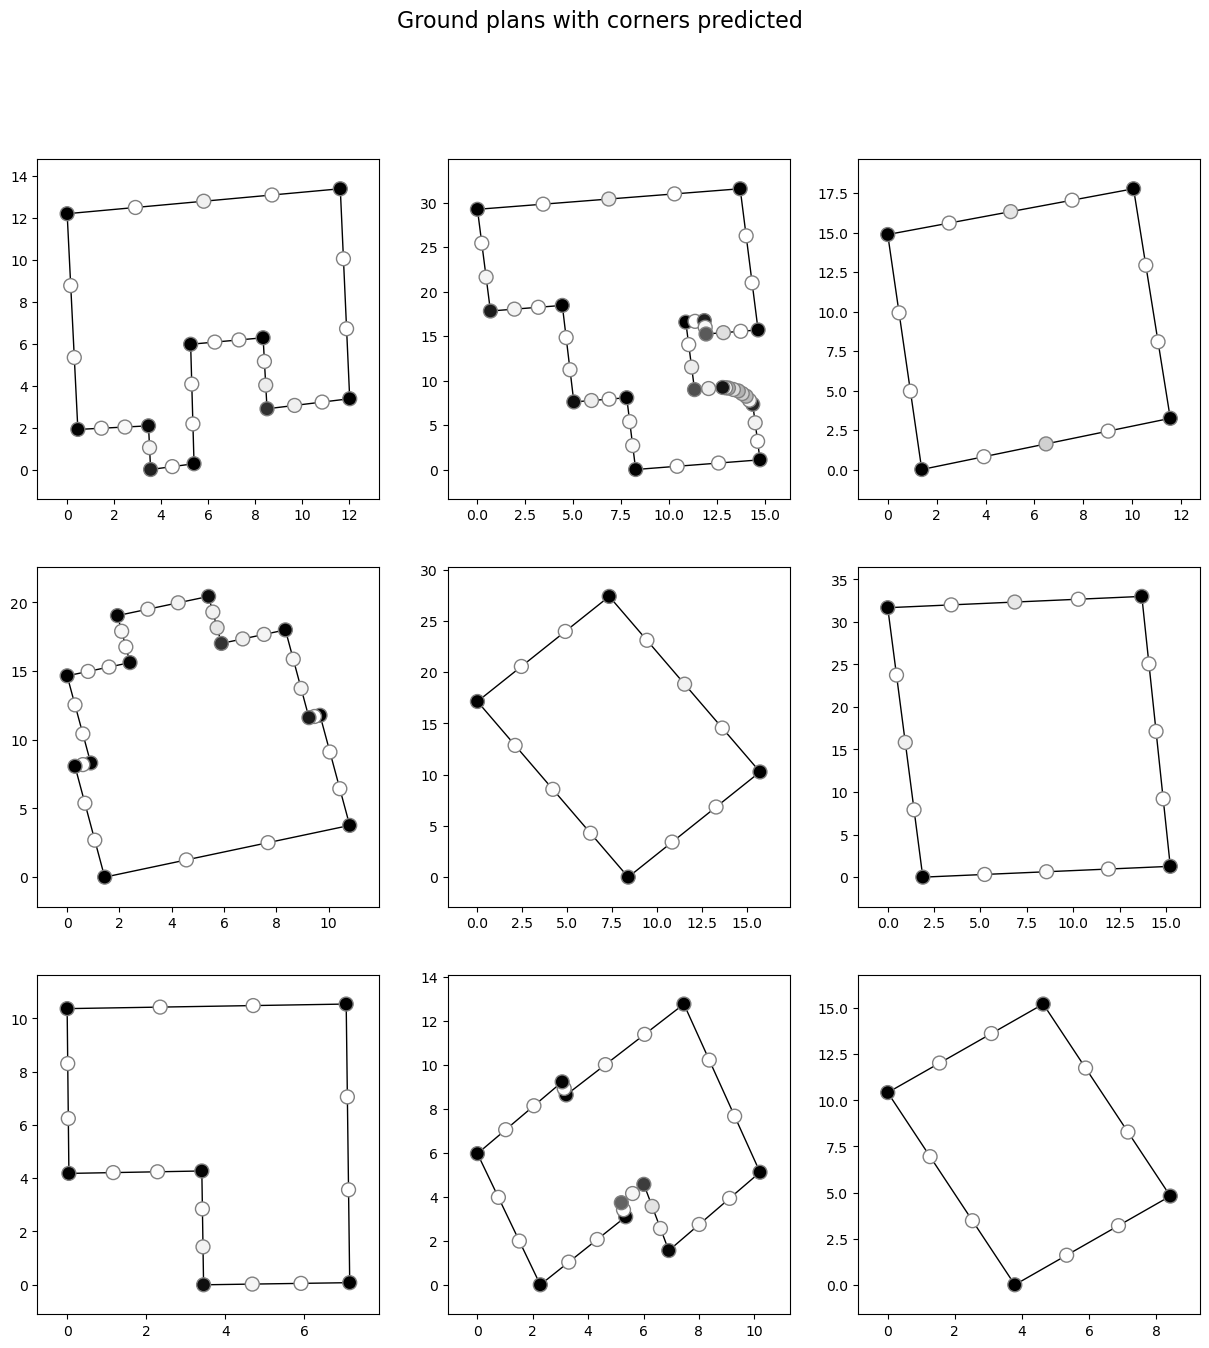

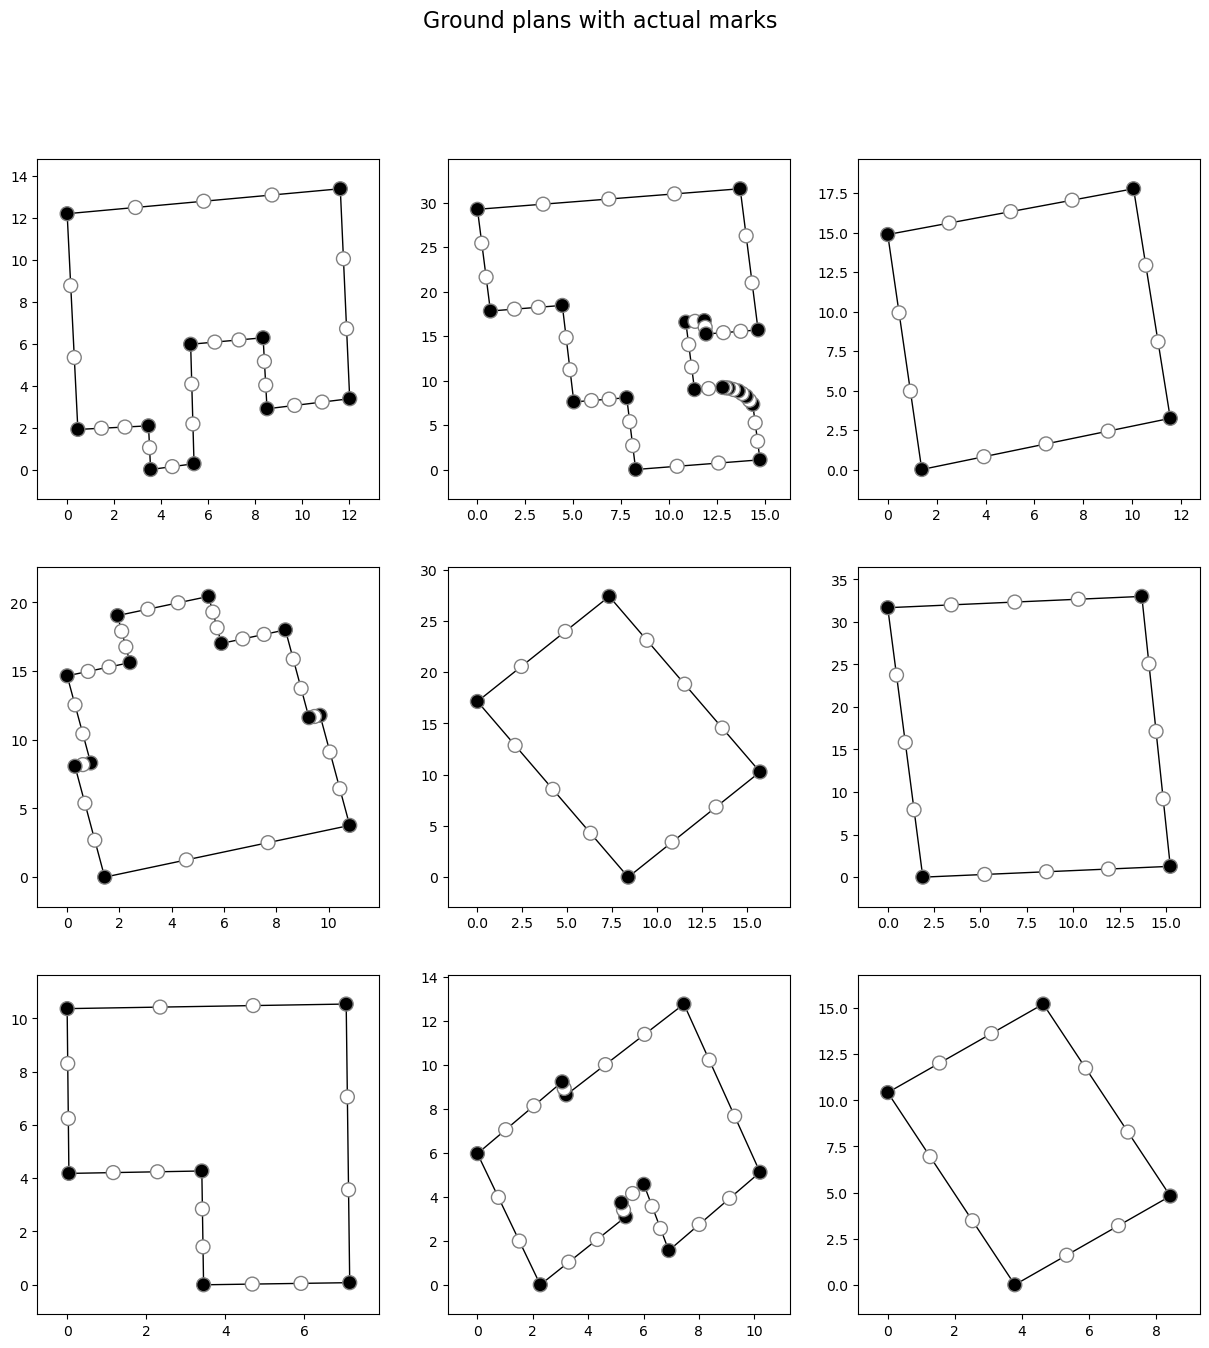

In [11]:
import pyproj

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Ground plans with corners predicted', fontsize=16)
for ax, data in zip(axs.flat, test_disp):
    pred_y = model(data.to(device)).detach().cpu()
    
    pos = {}
    for i, coords in enumerate(data.x.cpu().numpy()):
        pos[i] = (coords[0], coords[1])
        
    g = to_networkx(data, to_undirected=True)
    
    # Predicted corner as node_color
    nx.draw(g, pos, ax=ax, node_size=100, node_color=pred_y, edgecolors='grey', cmap='binary')
    ax.axis("on")
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    
plt.show()

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Ground plans with actual marks', fontsize=16)
for ax, data in zip(axs.flat, test_disp):
    # pred_y = model(data.to(device)).detach().cpu()
    
    pos = {}
    for i, coords in enumerate(data.x.cpu().numpy()):
        pos[i] = (coords[0], coords[1])
        
    g = to_networkx(data, to_undirected=True)
    
    # Predicted corner as node_color
    nx.draw(g, pos, ax=ax, node_size=100, node_color=data.y.cpu().numpy(), edgecolors='grey', cmap='binary')
    ax.axis("on")
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    
plt.show()

In [2]:
import numpy as np
import torch
from torch_geometric.data import Data, Batch
import torch_geometric.nn as gnn
import torch.nn.functional as F

class MoveNet(torch.nn.Module): # To try things out
    def __init__(self):
        super(MoveNet, self).__init__()
        
        self.sage8_mean = gnn.SAGEConv(2, 8, aggr='mean', root_weight=True)
        self.sage16_mean = gnn.SAGEConv(8, 16, aggr='mean', root_weight=True)
        self.sage32_mean = gnn.SAGEConv(16, 32, aggr='mean', root_weight=True)
        self.sage64_mean = gnn.SAGEConv(32, 64, aggr='mean', root_weight=True)
        
        self.bn8_mean = gnn.BatchNorm(8)
        self.bn16_mean = gnn.BatchNorm(16)
        self.bn32_mean = gnn.BatchNorm(32)
        self.bn64_mean = gnn.BatchNorm(64)

        self.fc = gnn.Linear(64, 3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        m = self.sage8_mean(x, edge_index)
        m = self.bn8_mean(m)
        m = F.relu(m)
        
        m = self.sage16_mean(m, edge_index)
        m = self.bn16_mean(m)
        m = F.relu(m)
        
        m = self.sage32_mean(m, edge_index)
        m = self.bn32_mean(m)
        m = F.relu(m)
        
        m = self.sage64_mean(m, edge_index)
        m = self.bn64_mean(m)
        m = F.relu(m)
        
        m = self.fc(m)
        
        return F.log_softmax(m, dim=1)
    
class BuildingSimplModel(torch.nn.Module): # From Zhou's paper with some addition
    def __init__(self):
        super(BuildingSimplModel, self).__init__()
        self.rm_4 = gnn.SAGEConv(2, 4, aggr='mean')
        self.rm_norm4 = gnn.BatchNorm(4)
        
        self.rm_8 = gnn.SAGEConv(4, 8, aggr='mean')
        self.rm_norm8 = gnn.BatchNorm(8)
        
        self.rm_64 = gnn.SAGEConv(8, 64, aggr='mean')
        self.rm_norm64 = gnn.BatchNorm(64)
        
        self.rm_32 = gnn.SAGEConv(64, 32, aggr='mean')
        self.rm_norm32 = gnn.BatchNorm(32)
        
        self.rm_16 = gnn.SAGEConv(32, 16, aggr='mean')
        self.rm_norm16 = gnn.BatchNorm(16)
        
        self.rm_3 = gnn.SAGEConv(16, 3, aggr='mean')
        
        # ------------
        
        self.mv_4 = gnn.SAGEConv(2, 4, aggr='mean')
        self.mv_norm4 = gnn.BatchNorm(4)
        
        self.mv_8 = gnn.SAGEConv(4, 8, aggr='mean')
        self.mv_norm8 = gnn.BatchNorm(8)
        
        self.mv_rm = gnn.SAGEConv(8 + 3, 64, aggr='mean')
        self.mv_rm_norm = gnn.BatchNorm(64)
        
        self.x_mv_32 = gnn.SAGEConv(64, 32, aggr='mean')
        self.x_mv_norm32 = gnn.BatchNorm(32)
        self.x_mv_16 = gnn.SAGEConv(32, 16, aggr='mean')
        self.x_mv_norm16 = gnn.BatchNorm(16)
        self.x_mv_fc = gnn.Linear(16, 1)
        
        self.y_mv_32 = gnn.SAGEConv(64, 32, aggr='mean')
        self.y_mv_norm32 = gnn.BatchNorm(32)
        self.y_mv_16 = gnn.SAGEConv(32, 16, aggr='mean')
        self.y_mv_norm16 = gnn.BatchNorm(16)
        self.y_mv_fc = gnn.Linear(16, 1)
        
        self.loss_weights = torch.nn.Parameter(data=torch.ones(3).uniform_(0.2, 1), requires_grad=True)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        op = F.relu( self.rm_norm4( self.rm_4(x, edge_index)))
        
        op = F.relu( self.rm_norm8( self.rm_8(op, edge_index)))
        
        op = F.relu( self.rm_norm64( self.rm_64(op, edge_index)))
        
        op = F.relu( self.rm_norm32( self.rm_32(op, edge_index)))

        op = F.relu( self.rm_norm16( self.rm_16(op, edge_index)))

        op_scores = self.rm_3(op, edge_index)
        
        op_probs = F.log_softmax(op_scores, dim=1)
        
        op_labels = op_probs.argmax(1)
        
        move_only = torch.where(op_labels == 1, 1, 0)
        
        # ------------
        
        mv = F.relu( self.mv_norm4( self.mv_4(x, edge_index)))
        
        mv = F.relu( self.mv_norm8( self.mv_8(mv, edge_index)))
        
        mv = F.relu( self.mv_rm_norm( self.mv_rm( torch.cat((mv, op_scores), 1), edge_index)))
        
        # ------------
        
        x_mv = F.relu( self.x_mv_norm32( self.x_mv_32(mv, edge_index)))
        
        x_mv = F.relu( self.x_mv_norm16( self.x_mv_16(x_mv, edge_index)))
        
        x_mv = self.x_mv_fc(x_mv)
        
        x_mv = torch.mul(x_mv.squeeze(), move_only)
        
        # ------------
        
        y_mv = F.relu( self.y_mv_norm32( self.y_mv_32(mv, edge_index)))
        
        y_mv = F.relu( self.y_mv_norm16( self.y_mv_16(y_mv, edge_index)))
        
        y_mv = self.y_mv_fc(y_mv)
        
        y_mv = torch.mul(y_mv.squeeze(), move_only)
        
        
        return op_probs, x_mv, y_mv
    
    def get_multi_losses(self, losses):
        sum_weighted_loss = 0.0
        for i in range(len(losses)):
            factor = 1.0 / ( 2 * self.loss_weights[i] )
            sum_weighted_loss = sum_weighted_loss + (factor * losses[i]) + torch.log(1 + self.loss_weights[i])
        return sum_weighted_loss
        

In [3]:
mo = BuildingSimplModel()
mo.parameters()

<generator object Module.parameters at 0x7f73ebc12180>